<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 70px">

# Client Project: Estimating Neighborhood Affluence with Yelp

<i>
                
                Submitted by Shannon Bingham and Roy Kim
</i>

 
## Problem Statement
The goal of the project is to estimate the affluence of a neighborhood based on the number of `$` of businesses and services (according to Yelp) in a given neighborhood (`$`, `$$`, `$$$`, `$$$$`). The project takes a list of zip codes as input and estimates the wealth of the locality. While traditional methods typically estimate wealth of a locality based on demographic characteristics (e.g. income or unemployment rate), the novelty of this approach is in its use of big data related to commercial activity and cost of product and services as an indicator for affluency.

## Notebook Description
This notebook contains python code that is used in clean the input data, exploratory data analysis, and feature engineering.

#### Data Source
| File Name | Description | Source |
| :------------ | :------------ | :------------ |
| yelp.api.zip{zip}.csv |Yelp business data for zip codes (all) |  Work files generated during data collection. |
| yelp.summary.zip{zip}.csv |Yelp summary data for zip codes (all) |  Work files generated during data collection.
| irs_agi.csv |Average adjusted gross income (all zip codes) |  Work file generated during data collection. |



#### Data Dictionary
| Output | Description | File Name |
| :------------ | :-------------- | :-------------- |
| zipcode | 5-digit Zip code | composite_zip_WI.csv |
| features | All features used to models | composite_zip_WI.csv |
| average_agi | Average agi (target variable) | composite_zip_WI.csv |


### Set up environment.

In [1]:
# Import needed packages.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pathname pattern expansion module.
import glob

# View plot within notebook.
%matplotlib inline

# Increase number of columns that can be viewed in notebook.
pd.set_option('display.max_columns', 500)

# Set random seed for reproducibility.
import random
random.seed(42)

### Load data.

In [2]:
# Load yelp summary data.  Use glob to locate files.
zip_df = pd.concat([pd.read_csv(f, dtype={'zipcode': 'str'})  
                    for f in glob.glob('./data/yelp_summary_zip5*.csv')], 
                    ignore_index = True, sort=False)

# Sort the data by zipcode.
zip_df.sort_values(by=['zipcode'],inplace=True)

# Reset index.
zip_df.reset_index(drop=True, inplace=True)

# Take a look.
zip_df.head()

,zipcode,n_business,n_d1,n_d2,n_d3,n_d4,n_review,n_s1,n_s1plus,n_s2,n_s2plus,n_s3,n_s3plus,n_s4,n_s4plus,n_s5
0,53004,64,26,37,0,1,1395,3,11,18,88,228,325,262,423,37
1,53006,8,5,3,0,0,123,0,8,0,0,49,0,34,24,8
2,53018,363,177,173,13,0,10591,30,156,243,389,1750,3121,3112,1552,238
3,53022,112,46,63,3,0,3469,0,40,291,331,617,1147,822,192,29
4,53024,228,94,127,6,1,7464,3,148,327,361,1204,2526,1855,985,55


In [3]:
# Load irs agi data file.

# Locate the file.
agi_csv = (f'./data/irs_agi.csv')

# Load the data.  
agi_df = pd.read_csv(agi_csv,dtype={'zipcode': 'str'})

# Take a look at the data.
agi_df.head()

,zipcode,average_agi,n_returns
0,35004,55202,5210
1,35005,38967,3100
2,35006,47595,1200
3,35007,57753,11940
4,35010,48045,7910


In [4]:
# Merge the yelp zip code and agi data.
zip_df = pd.merge(left=zip_df,right=agi_df, 
                 left_on='zipcode', right_on='zipcode')

# Verify merge.
zip_df.head()

,zipcode,n_business,n_d1,n_d2,n_d3,n_d4,n_review,n_s1,n_s1plus,n_s2,n_s2plus,n_s3,n_s3plus,n_s4,n_s4plus,n_s5,average_agi,n_returns
0,53004,64,26,37,0,1,1395,3,11,18,88,228,325,262,423,37,67920,1750
1,53006,8,5,3,0,0,123,0,8,0,0,49,0,34,24,8,60714,920
2,53018,363,177,173,13,0,10591,30,156,243,389,1750,3121,3112,1552,238,121996,3980
3,53022,112,46,63,3,0,3469,0,40,291,331,617,1147,822,192,29,77378,10140
4,53024,228,94,127,6,1,7464,3,148,327,361,1204,2526,1855,985,55,81371,9280


In [5]:
# Take a look at the data.
zip_df.shape

(96, 18)

In [6]:
# Load yelp detail data that contains categories.  Use glob to locate files.
zip_cat_df = pd.concat([pd.read_csv(f, dtype={'zipcode': 'str'})  
                    for f in glob.glob('./data/yelp_api_zip5*.csv')], 
                    ignore_index = True, sort=False)

# Sort the data by zipcode.
zip_cat_df.sort_values(by=['zipcode'],inplace=True)

# # Reset index.
zip_cat_df.reset_index(drop=True, inplace=True)

# # Take a look at the data.
zip_cat_df.head()

,zipcode,name,price,rating,review_count,categories
0,53004,Fredonia Family Restaurant,$$,3.0,12,"[{'alias': 'tradamerican', 'title': 'American ..."
1,53004,Schooner Pub,$,3.5,20,"[{'alias': 'bars', 'title': 'Bars'}, {'alias':..."
2,53004,Riverview Inn-the Next Generation,$$,4.0,12,"[{'alias': 'pizza', 'title': 'Pizza'}]"
3,53004,China King,$,3.5,13,"[{'alias': 'chinese', 'title': 'Chinese'}]"
4,53004,The Cedar Beach Inn,$$,3.5,5,"[{'alias': 'venues', 'title': 'Venues & Event ..."


 ## Data Cleaning 
 
 **Process:** 
 
- Remove duplicates.
- Handle mis-matched dtypes.
- Drop unneeded features.
- Handle null values.
- Handle outliers (None found)

### Remove duplicates.

In [7]:
# Drop duplicates.
zip_df.drop_duplicates(subset=['zipcode'], 
                         keep='first', inplace=True)

# Reset index.
zip_df.reset_index(drop=True, inplace=True)

# Verify update.
zip_df.shape

(96, 18)

### Handle mis-matched dtypes.
All columns have expected data types.

In [8]:
# Check initial data types of the columns.
zip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 18 columns):
zipcode        96 non-null object
n_business     96 non-null int64
n_d1           96 non-null int64
n_d2           96 non-null int64
n_d3           96 non-null int64
n_d4           96 non-null int64
n_review       96 non-null int64
n_s1           96 non-null int64
n_s1plus       96 non-null int64
n_s2           96 non-null int64
n_s2plus       96 non-null int64
n_s3           96 non-null int64
n_s3plus       96 non-null int64
n_s4           96 non-null int64
n_s4plus       96 non-null int64
n_s5           96 non-null int64
average_agi    96 non-null int64
n_returns      96 non-null int64
dtypes: int64(17), object(1)
memory usage: 13.6+ KB


### Drop unneeded features.

In [9]:
# Drop n_returns (original source was the IRS AGI file).
zip_df.drop(['n_returns'], inplace=True, axis=1)

# Verify number of columns.
zip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 17 columns):
zipcode        96 non-null object
n_business     96 non-null int64
n_d1           96 non-null int64
n_d2           96 non-null int64
n_d3           96 non-null int64
n_d4           96 non-null int64
n_review       96 non-null int64
n_s1           96 non-null int64
n_s1plus       96 non-null int64
n_s2           96 non-null int64
n_s2plus       96 non-null int64
n_s3           96 non-null int64
n_s3plus       96 non-null int64
n_s4           96 non-null int64
n_s4plus       96 non-null int64
n_s5           96 non-null int64
average_agi    96 non-null int64
dtypes: int64(16), object(1)
memory usage: 12.8+ KB


### Handle null values.
No null values found in data.

In [10]:
# Count number of nulls.
sum(zip_df.isnull().sum())

0

 ##  Exploratory Data Analysis 

In [11]:
# Generate descriptive statistics on agi (average gross income).
# Use the mean and std to identify outliers.
zip_df['average_agi'].describe()

count        96.000000
mean      63756.177083
std       20532.617162
min       22101.000000
25%       52588.000000
50%       60948.000000
75%       69256.500000
max      180693.000000
Name: average_agi, dtype: float64

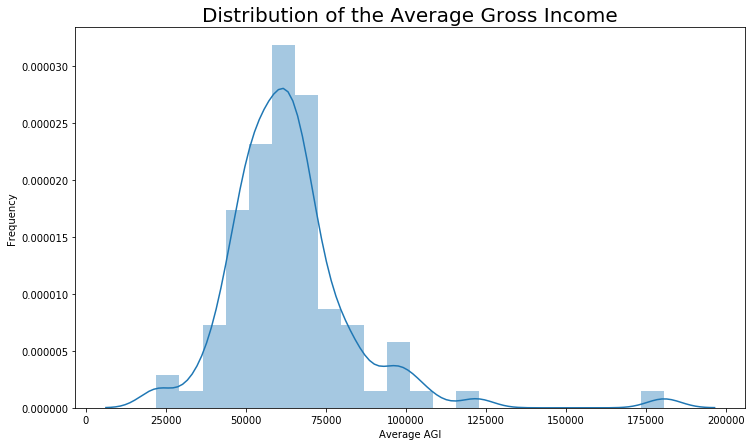

In [12]:
# Visualize distribution of average_agi.

# Set up figure.
plt.figure(figsize=(12,7))

# Create histogram.
ax = sns.distplot(zip_df['average_agi'])

# Set labels and title.
plt.xlabel("Average AGI")
plt.ylabel("Frequency")
plt.title('Distribution of the Average Gross Income', fontsize=20)

# Save figure.
plt.savefig('./images/02_EDA-AGI-distplot', 
            bbox_inches='tight');

In [13]:
# Use .describe output to identify outliers. 
zip_df['average_agi'].describe()

count        96.000000
mean      63756.177083
std       20532.617162
min       22101.000000
25%       52588.000000
50%       60948.000000
75%       69256.500000
max      180693.000000
Name: average_agi, dtype: float64

In [14]:
# Set threshold for outliers (mean +- 2 standard deviations).
outlier_threshold_low  = 64698.25 - (21786.45 * 2)
outlier_threshold_high = 64698.25 + (21786.45 * 2)

print(f' Outlier cutoff values are {outlier_threshold_low} and {outlier_threshold_high}')

 Outlier cutoff values are 21125.35 and 108271.15


In [15]:
# Look at the zipcodes with outlier agi values.
zip_df[zip_df['average_agi'] < outlier_threshold_low]

,zipcode,n_business,n_d1,n_d2,n_d3,n_d4,n_review,n_s1,n_s1plus,n_s2,n_s2plus,n_s3,n_s3plus,n_s4,n_s4plus,n_s5,average_agi


In [16]:
# Look at the zipcodes with outlier agi values.  
zip_df[zip_df['average_agi'] > outlier_threshold_high]

,zipcode,n_business,n_d1,n_d2,n_d3,n_d4,n_review,n_s1,n_s1plus,n_s2,n_s2plus,n_s3,n_s3plus,n_s4,n_s4plus,n_s5,average_agi
2,53018,363,177,173,13,0,10591,30,156,243,389,1750,3121,3112,1552,238,121996
14,53092,538,241,284,12,1,19716,48,556,768,1090,2892,6088,5739,2452,83,180693


In [17]:
# Generate descriptive statistics on number of businesses.
zip_df['n_business'].describe()

count     96.000000
mean     218.979167
std      225.810586
min        8.000000
25%       62.500000
50%      137.500000
75%      257.000000
max      903.000000
Name: n_business, dtype: float64

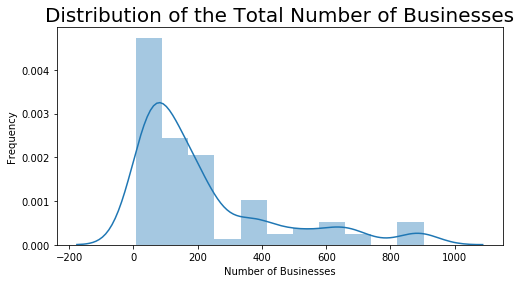

In [18]:
# Visualize distribution of n_business.

# Set up figure.
plt.figure(figsize=(8,4))

# Create histogram.
ax = sns.distplot(zip_df['n_business'])

# Set labels and title.
plt.xlabel("Number of Businesses")
plt.ylabel("Frequency")
plt.title('Distribution of the Total Number of Businesses', fontsize=20);

In [19]:
# Generate descriptive statistics on number of reviews.
zip_df['n_review'].describe()

count       96.000000
mean     11490.968750
std      19107.025076
min        123.000000
25%       1452.750000
50%       3522.000000
75%      10268.500000
max      80015.000000
Name: n_review, dtype: float64

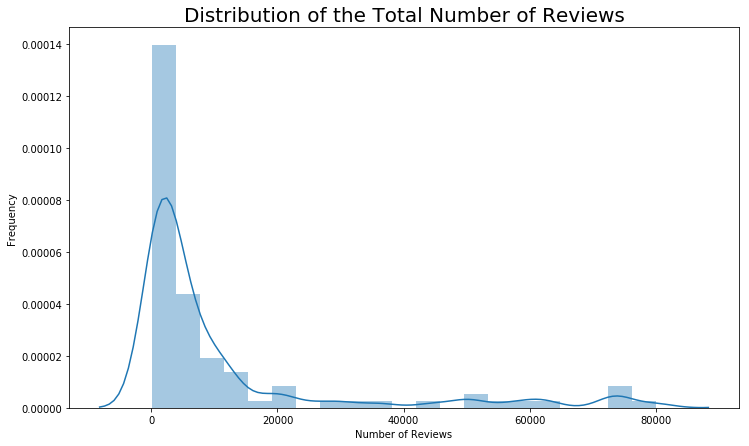

In [20]:
# Visualize distribution of n_review.

# Set up figure.
plt.figure(figsize=(12,7))

# Create histogram.
ax = sns.distplot(zip_df['n_review'])

# Set labels and title.
plt.xlabel("Number of Reviews")
plt.ylabel("Frequency")
plt.title('Distribution of the Total Number of Reviews', fontsize=20);

 ##  Feature Engineering 
 
 **Process:**
 
 In order to find signal, features are engineered to capture the number and proportions of prices and review stars (ratings) within a given business and its selected categories.  Features should be added/deleted/changed as more data is sampled and the model is refined over time.

In [21]:
# Engineer features based on proportion of price to the number of businesses.

# Calculate proportion of ge $$. 
zip_df['p_ge_d2'] = round((zip_df[f'n_d2']  + 
                           zip_df[f'n_d3']  + 
                           zip_df[f'n_d4']) / 
                           zip_df['n_business'], 2)

# Calculate proportion of ge $$$. 
zip_df['p_ge_d3'] = round((zip_df[f'n_d3']  + 
                           zip_df[f'n_d4']) / 
                           zip_df['n_business'], 2)

# Engineer a total score based on price.
zip_df['score_d'] = (zip_df['n_d1']     +
                    (zip_df['n_d2'] * 2) +
                    (zip_df['n_d3'] * 3) +
                    (zip_df['n_d4'] * 4))

# Calculate an average score based on price.
zip_df['score_avg_d'] = round(zip_df['score_d'] / 
                              zip_df['n_business'], 2)
               
# Verify columns.
zip_df.head()

,zipcode,n_business,n_d1,n_d2,n_d3,n_d4,n_review,n_s1,n_s1plus,n_s2,n_s2plus,n_s3,n_s3plus,n_s4,n_s4plus,n_s5,average_agi,p_ge_d2,p_ge_d3,score_d,score_avg_d
0,53004,64,26,37,0,1,1395,3,11,18,88,228,325,262,423,37,67920,0.59,0.02,104,1.62
1,53006,8,5,3,0,0,123,0,8,0,0,49,0,34,24,8,60714,0.38,0.00,11,1.38
2,53018,363,177,173,13,0,10591,30,156,243,389,1750,3121,3112,1552,238,121996,0.51,0.04,562,1.55
3,53022,112,46,63,3,0,3469,0,40,291,331,617,1147,822,192,29,77378,0.59,0.03,181,1.62
4,53024,228,94,127,6,1,7464,3,148,327,361,1204,2526,1855,985,55,81371,0.59,0.03,370,1.62


In [22]:
# Engineer features based on proportion of review stars to the number of reviews.

# Calculate proportion of ge ** . 
zip_df['p_ge_s2'] = round((zip_df[f'n_s2']     + 
                           zip_df[f'n_s2plus'] + 
                           zip_df[f'n_s3']     + 
                           zip_df[f'n_s3plus'] + 
                           zip_df[f'n_s4']     + 
                           zip_df[f'n_s4plus'] + 
                           zip_df[f'n_s5'])    / 
                           zip_df['n_review'], 2)

# Calculate proportion of ge ** and 1/2. 
zip_df['p_ge_s2plus'] = round((zip_df[f'n_s2plus'] +
                               zip_df[f'n_s3']     + 
                               zip_df[f'n_s3plus'] + 
                               zip_df[f'n_s4']     + 
                               zip_df[f'n_s4plus'] + 
                               zip_df[f'n_s5'])    / 
                               zip_df['n_review'], 2)

# Calculate proportion of ge ***. 
zip_df['p_ge_s3'] = round((zip_df[f'n_s3']     + 
                           zip_df[f'n_s3plus'] + 
                           zip_df[f'n_s4']     + 
                           zip_df[f'n_s4plus'] + 
                           zip_df[f'n_s5'])    / 
                           zip_df['n_review'], 2)

# Calculate proportion of ge *** and 1/2. 
zip_df['p_ge_s3plus'] = round((zip_df[f'n_s3plus'] +
                               zip_df[f'n_s4']     + 
                               zip_df[f'n_s4plus'] + 
                               zip_df[f'n_s5'])    / 
                               zip_df['n_review'], 2)


# Calculate proportion of ge ****. 
zip_df['p_ge_s4'] = round((zip_df[f'n_s4']     + 
                           zip_df[f'n_s4plus'] + 
                           zip_df[f'n_s5'])    / 
                           zip_df['n_review'], 2)

# Calculate proportion of ge **** and 1/2. 
zip_df['p_ge_s4plus'] = round((zip_df[f'n_s4plus'] + 
                               zip_df[f'n_s5'])    / 
                               zip_df['n_review'], 2)

# Calculate a total score based on reviews.
zip_df['score_s'] = (zip_df['n_s1']            +
                    (zip_df['n_s1plus'] * 1.5) +
                    (zip_df['n_s2'] * 2)       +
                    (zip_df['n_s2plus'] * 2.5) +
                    (zip_df['n_s3'] * 3)       +
                    (zip_df['n_s3plus'] * 3.5) +
                    (zip_df['n_s4'] * 4)       +
                    (zip_df['n_s4plus'] * 4.5) +
                    (zip_df['n_s5'] * 5)) 

# Calculate an average score based on reviews.
zip_df['score_avg_s'] = round(zip_df['score_s'] / 
                              zip_df['n_review'], 2)


# Verify columns.
zip_df.head()

,zipcode,n_business,n_d1,n_d2,n_d3,n_d4,n_review,n_s1,n_s1plus,n_s2,n_s2plus,n_s3,n_s3plus,n_s4,n_s4plus,n_s5,average_agi,p_ge_d2,p_ge_d3,score_d,score_avg_d,p_ge_s2,p_ge_s2plus,p_ge_s3,p_ge_s3plus,p_ge_s4,p_ge_s4plus,score_s,score_avg_s
0,53004,64,26,37,0,1,1395,3,11,18,88,228,325,262,423,37,67920,0.59,0.02,104,1.62,0.99,0.98,0.91,0.75,0.52,0.33,5233.5,3.75
1,53006,8,5,3,0,0,123,0,8,0,0,49,0,34,24,8,60714,0.38,0.00,11,1.38,0.93,0.93,0.93,0.54,0.54,0.26,443.0,3.60
2,53018,363,177,173,13,0,10591,30,156,243,389,1750,3121,3112,1552,238,121996,0.51,0.04,562,1.55,0.98,0.96,0.92,0.76,0.46,0.17,38518.0,3.64
3,53022,112,46,63,3,0,3469,0,40,291,331,617,1147,822,192,29,77378,0.59,0.03,181,1.62,0.99,0.90,0.81,0.63,0.30,0.06,11632.0,3.35
4,53024,228,94,127,6,1,7464,3,148,327,361,1204,2526,1855,985,55,81371,0.59,0.03,370,1.62,0.98,0.94,0.89,0.73,0.39,0.14,26362.0,3.53


In [23]:
# Set business category selection list to use in generation of category-specific engineered features.
selected_categories = set(['bagels', 'breweries', 'burgers', 'coffee',  
                           'french', 'gourmet', 'grocery', 
                           'steak', 'sushi', 'wine_bars'])

In [24]:
# Function: get_price_by_category.
# Collect price data for the selected categories, embedding the actual price value in the column name.
# Each row input to this function represents a single business. Each business is associated with one
# or more categories.  The output of this process is a list [zip, column name] for each of the
# business' associated categories that meets the selection criteria.

def get_price_by_category(row, selection):  
    
    # Restore categories to a list.
    row_categories = eval(row['categories'])
    
    # Initialize list.
    category_prices = []
    
    # Loop through categories identified for the business.
    for category in row_categories:
        
        for key, val in category.items():
            
            # Build column name and append to returned list.
            if key == 'alias' and val in selection:
                
                # Count number of $.
                n = len(row['price'])
                
                # Build column name.
                col = (f'n_d{n}_{val}')
                
                # Save zipcode and column name.
                category_prices.append((row['zipcode'], col))
 
    # Return the category prices.
    if len(category_prices) > 0:
        return category_prices
    else:
        pass

In [25]:
# Initialize price features in dataframe.  Price features have a naming format 
# that includes the number of $ (i+1) and the name of the category (c).
for c in selected_categories:
    for i in range(4):
        
        # Add column.
        zip_df[f'n_d{i+1}_{c}'] = 0
        
        
# Assign price data to each category.
# Initialize list.  This list is essentially a file of update transactions.
categories_with_prices = []

# Call function to return list of prices in the category.
categories_with_prices = zip_cat_df.apply(get_price_by_category,
                                 selection=selected_categories, axis=1)

# Load category price data (transactions) to the dataframe.
# Loop through the list.
for b in categories_with_prices:

    # Check if category data was selected.
    if b != None:
        
        # Loop through all the categories.
        for category_with_price in b:
            
            # Increment the value in the column.
            row_idx = zip_df.index[zip_df['zipcode'] == category_with_price[0]]
            zip_df.loc[row_idx, category_with_price[1]] += 1

                              
# Verify columns.
zip_df.head()

,zipcode,n_business,n_d1,n_d2,n_d3,n_d4,n_review,n_s1,n_s1plus,n_s2,n_s2plus,n_s3,n_s3plus,n_s4,n_s4plus,n_s5,average_agi,p_ge_d2,p_ge_d3,score_d,score_avg_d,p_ge_s2,p_ge_s2plus,p_ge_s3,p_ge_s3plus,p_ge_s4,p_ge_s4plus,score_s,score_avg_s,n_d1_gourmet,n_d2_gourmet,n_d3_gourmet,n_d4_gourmet,n_d1_wine_bars,n_d2_wine_bars,n_d3_wine_bars,n_d4_wine_bars,n_d1_burgers,n_d2_burgers,n_d3_burgers,n_d4_burgers,n_d1_sushi,n_d2_sushi,n_d3_sushi,n_d4_sushi,n_d1_coffee,n_d2_coffee,n_d3_coffee,n_d4_coffee,n_d1_grocery,n_d2_grocery,n_d3_grocery,n_d4_grocery,n_d1_steak,n_d2_steak,n_d3_steak,n_d4_steak,n_d1_bagels,n_d2_bagels,n_d3_bagels,n_d4_bagels,n_d1_french,n_d2_french,n_d3_french,n_d4_french,n_d1_breweries,n_d2_breweries,n_d3_breweries,n_d4_breweries
0,53004,64,26,37,0,1,1395,3,11,18,88,228,325,262,423,37,67920,0.59,0.02,104,1.62,0.99,0.98,0.91,0.75,0.52,0.33,5233.5,3.75,0,0,0,0,0,1,0,0,6,2,0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,53006,8,5,3,0,0,123,0,8,0,0,49,0,34,24,8,60714,0.38,0.00,11,1.38,0.93,0.93,0.93,0.54,0.54,0.26,443.0,3.60,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,53018,363,177,173,13,0,10591,30,156,243,389,1750,3121,3112,1552,238,121996,0.51,0.04,562,1.55,0.98,0.96,0.92,0.76,0.46,0.17,38518.0,3.64,0,0,1,0,0,8,1,0,22,14,0,0,0,6,0,0,33,10,0,0,0,3,1,0,1,3,3,0,1,0,0,0,0,0,0,0,0,4,0,0
3,53022,112,46,63,3,0,3469,0,40,291,331,617,1147,822,192,29,77378,0.59,0.03,181,1.62,0.99,0.90,0.81,0.63,0.30,0.06,11632.0,3.35,0,0,1,0,0,0,0,0,8,7,0,0,0,2,0,0,6,4,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,53024,228,94,127,6,1,7464,3,148,327,361,1204,2526,1855,985,55,81371,0.59,0.03,370,1.62,0.98,0.94,0.89,0.73,0.39,0.14,26362.0,3.53,0,1,2,0,0,6,0,0,14,11,0,0,0,1,0,0,11,9,1,0,0,1,2,0,0,2,0,0,1,1,0,0,0,0,0,0,1,0,0,0


In [26]:
# Engineer a variety of features based on price within the business categories.

# Initialize total score for all selected categories.
zip_df['score_d_categories'] = 0

# Initialize columns in dataframe.
for c in selected_categories:
              
    # Add column for total number of businesses in category.
    zip_df[f'n_{c}'] = (zip_df[f'n_d1_{c}'] + zip_df[f'n_d2_{c}'] +
                        zip_df[f'n_d3_{c}'] + zip_df[f'n_d4_{c}'])

    # Initialize proportions to 0 in case no businesses in category.
    zip_df[f'p_{c}']       = 0
    zip_df[f'p_ge_d2_{c}'] = 0
    zip_df[f'p_ge_d3_{c}'] = 0

    # Calculate proportion of category to total number of buinesses. 
    zip_df.loc[zip_df[f'n_{c}'] != 0, f'p_{c}']       = round(zip_df[f'n_{c}'] / 
                                                              zip_df['n_business'], 2)

    # Calculate proportion of ge $$ within category. 
    zip_df.loc[zip_df[f'n_{c}'] != 0, f'p_ge_d2_{c}'] = (round((zip_df[f'n_d2_{c}'] + 
                                                                zip_df[f'n_d3_{c}'] + 
                                                                zip_df[f'n_d4_{c}']) / 
                                                                zip_df[f'n_{c}'], 2))

    # Calculate proportion of ge $$$ within category. 
    zip_df.loc[zip_df[f'n_{c}'] != 0, f'p_ge_d3_{c}'] = (round((zip_df[f'n_d3_{c}'] +  
                                                                zip_df[f'n_d4_{c}']) / 
                                                                zip_df[f'n_{c}'], 2))  
    
    # Calculate score.
    zip_df[f'score_d_{c}'] = (zip_df[f'n_d1_{c}']      +
                             (zip_df[f'n_d2_{c}'] * 2) +
                             (zip_df[f'n_d3_{c}'] * 3) +
                             (zip_df[f'n_d4_{c}'] * 4))
    
    # Increment score.
    zip_df['score_d_categories'] += zip_df[f'score_d_{c}']
                              
# Verify columns.
zip_df.head()

,zipcode,n_business,n_d1,n_d2,n_d3,n_d4,n_review,n_s1,n_s1plus,n_s2,n_s2plus,n_s3,n_s3plus,n_s4,n_s4plus,n_s5,average_agi,p_ge_d2,p_ge_d3,score_d,score_avg_d,p_ge_s2,p_ge_s2plus,p_ge_s3,p_ge_s3plus,p_ge_s4,p_ge_s4plus,score_s,score_avg_s,n_d1_gourmet,n_d2_gourmet,n_d3_gourmet,n_d4_gourmet,n_d1_wine_bars,n_d2_wine_bars,n_d3_wine_bars,n_d4_wine_bars,n_d1_burgers,n_d2_burgers,n_d3_burgers,n_d4_burgers,n_d1_sushi,n_d2_sushi,n_d3_sushi,n_d4_sushi,n_d1_coffee,n_d2_coffee,n_d3_coffee,n_d4_coffee,n_d1_grocery,n_d2_grocery,n_d3_grocery,n_d4_grocery,n_d1_steak,n_d2_steak,n_d3_steak,n_d4_steak,n_d1_bagels,n_d2_bagels,n_d3_bagels,n_d4_bagels,n_d1_french,n_d2_french,n_d3_french,n_d4_french,n_d1_breweries,n_d2_breweries,n_d3_breweries,n_d4_breweries,score_d_categories,n_gourmet,p_gourmet,p_ge_d2_gourmet,p_ge_d3_gourmet,score_d_gourmet,n_wine_bars,p_wine_bars,p_ge_d2_wine_bars,p_ge_d3_wine_bars,score_d_wine_bars,n_burgers,p_burgers,p_ge_d2_burgers,p_ge_d3_burgers,score_d_burgers,n_sushi,p_sushi,p_ge_d2_sushi,p_ge_d3_sushi,score_d_sushi,n_coffee,p_coffee,p_ge_d2_coffee,p_ge_d3_coffee,score_d_coffee,n_grocery,p_grocery,p_ge_d2_grocery,p_ge_d3_grocery,score_d_grocery,n_steak,p_steak,p_ge_d2_steak,p_ge_d3_steak,score_d_steak,n_bagels,p_bagels,p_ge_d2_bagels,p_ge_d3_bagels,score_d_bagels,n_french,p_french,p_ge_d2_french,p_ge_d3_french,score_d_french,n_breweries,p_breweries,p_ge_d2_breweries,p_ge_d3_breweries,score_d_breweries
0,53004,64,26,37,0,1,1395,3,11,18,88,228,325,262,423,37,67920,0.59,0.02,104,1.62,0.99,0.98,0.91,0.75,0.52,0.33,5233.5,3.75,0,0,0,0,0,1,0,0,6,2,0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0.00,0.0,0.00,0,1,0.02,1.0,0.00,2,8,0.12,0.25,0.0,10,0,0.00,0.0,0.0,0,5,0.08,0.20,0.00,6,0,0.00,0.0,0.00,0,2,0.03,1.00,0.00,4,0,0.00,0.0,0.0,0,0,0.0,0.0,0.0,0,0,0.00,0.0,0.0,0
1,53006,8,5,3,0,0,123,0,8,0,0,49,0,34,24,8,60714,0.38,0.00,11,1.38,0.93,0.93,0.93,0.54,0.54,0.26,443.0,3.60,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0.00,0.0,0.00,0,0,0.00,0.0,0.00,0,4,0.50,0.25,0.0,5,0,0.00,0.0,0.0,0,1,0.12,0.00,0.00,1,0,0.00,0.0,0.00,0,0,0.00,0.00,0.00,0,0,0.00,0.0,0.0,0,0,0.0,0.0,0.0,0,0,0.00,0.0,0.0,0
2,53018,363,177,173,13,0,10591,30,156,243,389,1750,3121,3112,1552,238,121996,0.51,0.04,562,1.55,0.98,0.96,0.92,0.76,0.46,0.17,38518.0,3.64,0,0,1,0,0,8,1,0,22,14,0,0,0,6,0,0,33,10,0,0,0,3,1,0,1,3,3,0,1,0,0,0,0,0,0,0,0,4,0,0,171,1,0.00,1.0,1.00,3,9,0.02,1.0,0.11,19,36,0.10,0.39,0.0,50,6,0.02,1.0,0.0,12,43,0.12,0.23,0.00,53,4,0.01,1.0,0.25,9,7,0.02,0.86,0.43,16,1,0.00,0.0,0.0,1,0,0.0,0.0,0.0,0,4,0.01,1.0,0.0,8
3,53022,112,46,63,3,0,3469,0,40,291,331,617,1147,822,192,29,77378,0.59,0.03,181,1.62,0.99,0.90,0.81,0.63,0.30,0.06,11632.0,3.35,0,0,1,0,0,0,0,0,8,7,0,0,0,2,0,0,6,4,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,54,1,0.01,1.0,1.00,3,0,0.00,0.0,0.00,0,15,0.13,0.47,0.0,22,2,0.02,1.0,0.0,4,11,0.10,0.45,0.09,17,1,0.01,1.0,1.00,3,2,0.02,1.00,0.50,5,0,0.00,0.0,0.0,0,0,0.0,0.0,0.0,0,0,0.00,0.0,0.0,0
4,53024,228,94,127,6,1,7464,3,148,327,361,1204,2526,1855,985,55,81371,0.59,0.03,370,1.62,0.98,0.94,0.89,0.73,0.39,0.14,26362.0,3.53,0,1,2,0,0,6,0,0,14,11,0,0,0,1,0,0,11,9,1,0,0,1,2,0,0,2,0,0,1,1,0,0,0,0,0,0,1,0,0,0,106,3,0.01,1.0,0.67,8,6,0.03,1.0,0.00,12,25,0.11,0.44,0.0,36,1,0.00,1.0,0.0,2,21,0.09,0.48,0.05,32,3,0.01,1.0,0.67,8,2,0.01,1.00,0.00,4,2,0.01,0.5,0.0,3,0,0.0,0.0,0.0,0,1,0.00,0.0,0.0,1


In [27]:
# Function: get_rating_by_category.
# Collect rating data for the selected categories, embedding the actual rating value in the column name.
# Each row input to this function represents a single business. Each business is associated with one
# or more categories.  The output of this process is a list [zip, column name] for each of the
# business' associated categories that meets the selection criteria.

def get_rating_by_category(row, selection):  
    
    # Restore categories to a list.
    row_categories = eval(row['categories'])
    
    # Initialize list.
    category_ratings = []
    
    # Loop through categories identified for the business.
    for category in row_categories:
        
        for key, val in category.items():
            
            # Build column name and append to returned list.
            if key == 'alias' and val in selection:
                
                # Count number of stars.  
                
                whole = int(row['rating'])
                half  = row['rating'] % 1
    
                if half == 0:
                    col = (f'n_s{whole}_{val}')
                else:
                    col = (f'n_s{whole}plus_{val}')
                
                # Save zipcode and column name.
                category_ratings.append((row['zipcode'], col))
 
    # Return the category ratings.
    if len(category_ratings) > 0:
        return category_ratings
    else:
        pass

In [28]:
# Initialize rating features in dataframe.  Rating features have a naming format 
# that includes the number of stars and the name of the category (c).
for c in selected_categories:
    
    # Add column.
    zip_df[f'n_s1_{c}']     = 0
    zip_df[f'n_s1plus_{c}'] = 0
    zip_df[f'n_s2_{c}']     = 0
    zip_df[f'n_s2plus_{c}'] = 0
    zip_df[f'n_s3_{c}']     = 0
    zip_df[f'n_s3plus_{c}'] = 0
    zip_df[f'n_s4_{c}']     = 0
    zip_df[f'n_s4plus_{c}'] = 0
    zip_df[f'n_s5_{c}']     = 0
    
# Collect rating data by categories.

# Assign rating data to each category.
# Initialize list.  This list is essentially a file of update transactions.
categories_with_ratings = []

# Call function to return list of prices in the category.
categories_with_ratings = zip_cat_df.apply(get_rating_by_category,
                                 selection=selected_categories, axis=1) 

# Load category rating data (transactions) to the dataframe.
# Loop through the list.
for b in categories_with_ratings:

    # Check if category data was selected.
    if b != None:
        
        # Loop through all the categories.
        for category_with_rating in b:
            
            # Increment the value in the column.
            row_idx = zip_df.index[zip_df['zipcode'] == category_with_rating[0]]
            zip_df.loc[row_idx, category_with_rating[1]] += 1

In [29]:
# Engineer a variety of features based on review stars within the business categories.

# Initialize total score for all selected categories.
zip_df['score_s_categories'] = 0

# Initialize columns in dataframe.
for c in selected_categories:
              
    # Add column for total number of reviews in category.
    zip_df[f'n_s_{c}'] = (zip_df[f'n_s1_{c}']     +
                          zip_df[f'n_s1plus_{c}'] + 
                          zip_df[f'n_s2_{c}']     +
                          zip_df[f'n_s2plus_{c}'] + 
                          zip_df[f'n_s3_{c}']     + 
                          zip_df[f'n_s3plus_{c}'] + 
                          zip_df[f'n_s4_{c}']     +
                          zip_df[f'n_s4plus_{c}'] + 
                          zip_df[f'n_s5_{c}'])

    # Initialize proportions to 0 in case no reviews in category.
    zip_df[f'p_s_{c}']         = 0
    zip_df[f'p_ge_s2_{c}']     = 0
    zip_df[f'p_ge_s2plus_{c}'] = 0
    zip_df[f'p_ge_s3_{c}']     = 0
    zip_df[f'p_ge_s3plus_{c}'] = 0
    zip_df[f'p_ge_s4_{c}']     = 0
    zip_df[f'p_ge_s4plus_{c}'] = 0
    zip_df[f'p_ge_s5_{c}']     = 0

    # Calculate proportion of category to total number of reviews. 
    zip_df.loc[zip_df[f'n_s_{c}'] != 0, f'p_s_{c}']     = round(zip_df[f'n_s_{c}'] / 
                                                                zip_df['n_review'], 2)

    # Calculate proportion of ge **. 
    zip_df.loc[zip_df[f'n_s_{c}'] != 0, f'p_ge_s2_{c}'] = round((zip_df[f'n_s2_{c}']     + 
                                                                 zip_df[f'n_s2plus_{c}'] +
                                                                 zip_df[f'n_s3_{c}']     + 
                                                                 zip_df[f'n_s3plus_{c}'] +
                                                                 zip_df[f'n_s4_{c}']     + 
                                                                 zip_df[f'n_s4plus_{c}'] +
                                                                 zip_df[f'n_s5_{c}'])    / 
                                                                 zip_df[f'n_s_{c}'], 2)

    # Calculate proportion of ** and 1/2. 
    zip_df.loc[zip_df[f'n_s_{c}'] != 0, f'p_ge_s2plus_{c}'] = round((zip_df[f'n_s2plus_{c}'] + 
                                                                     zip_df[f'n_s3_{c}']     + 
                                                                     zip_df[f'n_s3plus_{c}'] +
                                                                     zip_df[f'n_s4_{c}']     + 
                                                                     zip_df[f'n_s4plus_{c}'] +
                                                                     zip_df[f'n_s5_{c}'])    / 
                                                                     zip_df[f'n_s_{c}'], 2) 


    # Calculate proportion of ge ***.
    zip_df.loc[zip_df[f'n_s_{c}'] != 0, f'p_ge_s3_{c}'] = round((zip_df[f'n_s3_{c}']     + 
                                                                 zip_df[f'n_s3plus_{c}'] +
                                                                 zip_df[f'n_s4_{c}']     + 
                                                                 zip_df[f'n_s4plus_{c}'] +
                                                                 zip_df[f'n_s5_{c}'])    / 
                                                                 zip_df[f'n_s_{c}'], 2)



    # Calculate proportion of *** and 1/2.
    zip_df.loc[zip_df[f'n_s_{c}'] != 0, f'p_ge_s3plus_{c}'] = round((zip_df[f'n_s3plus_{c}'] +
                                                                     zip_df[f'n_s4_{c}']     + 
                                                                     zip_df[f'n_s4plus_{c}'] +
                                                                     zip_df[f'n_s5_{c}'])    / 
                                                                     zip_df[f'n_s_{c}'], 2)



    # Calculate proportion of ge ****.
    zip_df.loc[zip_df[f'n_s_{c}'] != 0, f'p_ge_s4_{c}'] = round((zip_df[f'n_s4_{c}']     + 
                                                                 zip_df[f'n_s4plus_{c}'] +
                                                                 zip_df[f'n_s5_{c}'])    / 
                                                                 zip_df[f'n_s_{c}'], 2)




    # Calculate proportion of **** and 1/2. 
    zip_df.loc[zip_df[f'n_s_{c}'] != 0, f'p_ge_s4plus_{c}'] = round((zip_df[f'n_s4plus_{c}'] +
                                                                     zip_df[f'n_s5_{c}'])    /  
                                                                     zip_df[f'n_s_{c}'], 2)


    # Calculate score.
    zip_df[f'score_s_{c}'] = (zip_df[f'n_s1_{c}']            +
                             (zip_df[f'n_s1plus_{c}'] * 1.5) +
                             (zip_df[f'n_s2_{c}'] * 2)       +
                             (zip_df[f'n_s2plus_{c}'] * 2.5) +
                             (zip_df[f'n_s3_{c}'] * 3)       +
                             (zip_df[f'n_s3plus_{c}'] * 3.5) +
                             (zip_df[f'n_s4_{c}'] * 4)       +
                             (zip_df[f'n_s4plus_{c}'] * 4.5) +
                             (zip_df[f'n_s5_{c}'] * 5))
                              
    # Increment score.
    zip_df['score_s_categories'] += zip_df[f'score_s_{c}']
                              
# Verify columns.
zip_df.head()

,zipcode,n_business,n_d1,n_d2,n_d3,n_d4,n_review,n_s1,n_s1plus,n_s2,n_s2plus,n_s3,n_s3plus,n_s4,n_s4plus,n_s5,average_agi,p_ge_d2,p_ge_d3,score_d,score_avg_d,p_ge_s2,p_ge_s2plus,p_ge_s3,p_ge_s3plus,p_ge_s4,p_ge_s4plus,score_s,score_avg_s,n_d1_gourmet,n_d2_gourmet,n_d3_gourmet,n_d4_gourmet,n_d1_wine_bars,n_d2_wine_bars,n_d3_wine_bars,n_d4_wine_bars,n_d1_burgers,n_d2_burgers,n_d3_burgers,n_d4_burgers,n_d1_sushi,n_d2_sushi,n_d3_sushi,n_d4_sushi,n_d1_coffee,n_d2_coffee,n_d3_coffee,n_d4_coffee,n_d1_grocery,n_d2_grocery,n_d3_grocery,n_d4_grocery,n_d1_steak,n_d2_steak,n_d3_steak,n_d4_steak,n_d1_bagels,n_d2_bagels,n_d3_bagels,n_d4_bagels,n_d1_french,n_d2_french,n_d3_french,n_d4_french,n_d1_breweries,n_d2_breweries,n_d3_breweries,n_d4_breweries,score_d_categories,n_gourmet,p_gourmet,p_ge_d2_gourmet,p_ge_d3_gourmet,score_d_gourmet,n_wine_bars,p_wine_bars,p_ge_d2_wine_bars,p_ge_d3_wine_bars,score_d_wine_bars,n_burgers,p_burgers,p_ge_d2_burgers,p_ge_d3_burgers,score_d_burgers,n_sushi,p_sushi,p_ge_d2_sushi,p_ge_d3_sushi,score_d_sushi,n_coffee,p_coffee,p_ge_d2_coffee,p_ge_d3_coffee,score_d_coffee,n_grocery,p_grocery,p_ge_d2_grocery,p_ge_d3_grocery,score_d_grocery,n_steak,p_steak,p_ge_d2_steak,p_ge_d3_steak,score_d_steak,n_bagels,p_bagels,p_ge_d2_bagels,p_ge_d3_bagels,score_d_bagels,n_french,p_french,p_ge_d2_french,p_ge_d3_french,score_d_french,n_breweries,p_breweries,p_ge_d2_breweries,p_ge_d3_breweries,score_d_breweries,n_s1_gourmet,n_s1plus_gourmet,n_s2_gourmet,n_s2plus_gourmet,n_s3_gourmet,n_s3plus_gourmet,n_s4_gourmet,n_s4plus_gourmet,n_s5_gourmet,n_s1_wine_bars,n_s1plus_wine_bars,n_s2_wine_bars,n_s2plus_wine_bars,n_s3_wine_bars,n_s3plus_wine_bars,n_s4_wine_bars,n_s4plus_wine_bars,n_s5_wine_bars,n_s1_burgers,n_s1plus_burgers,n_s2_burgers,n_s2plus_burgers,n_s3_burgers,n_s3plus_burgers,n_s4_burgers,n_s4plus_burgers,n_s5_burgers,n_s1_sushi,n_s1plus_sushi,n_s2_sushi,n_s2plus_sushi,n_s3_sushi,n_s3plus_sushi,n_s4_sushi,n_s4plus_sushi,n_s5_sushi,n_s1_coffee,n_s1plus_coffee,n_s2_coffee,n_s2plus_coffee,n_s3_coffee,n_s3plus_coffee,n_s4_coffee,n_s4plus_coffee,n_s5_coffee,n_s1_grocery,n_s1plus_grocery,n_s2_grocery,n_s2plus_grocery,n_s3_grocery,n_s3plus_grocery,n_s4_grocery,n_s4plus_grocery,n_s5_grocery,n_s1_steak,n_s1plus_steak,n_s2_steak,n_s2plus_steak,n_s3_steak,n_s3plus_steak,n_s4_steak,n_s4plus_steak,n_s5_steak,n_s1_bagels,n_s1plus_bagels,n_s2_bagels,n_s2plus_bagels,n_s3_bagels,n_s3plus_bagels,n_s4_bagels,n_s4plus_bagels,n_s5_bagels,n_s1_french,n_s1plus_french,n_s2_french,n_s2plus_french,n_s3_french,n_s3plus_french,n_s4_french,n_s4plus_french,n_s5_french,n_s1_breweries,n_s1plus_breweries,n_s2_breweries,n_s2plus_breweries,n_s3_breweries,n_s3plus_breweries,n_s4_breweries,n_s4plus_breweries,n_s5_breweries,score_s_categories,n_s_gourmet,p_s_gourmet,p_ge_s2_gourmet,p_ge_s2plus_gourmet,p_ge_s3_gourmet,p_ge_s3plus_gourmet,p_ge_s4_gourmet,p_ge_s4plus_gourmet,p_ge_s5_gourmet,score_s_gourmet,n_s_wine_bars,p_s_wine_bars,p_ge_s2_wine_bars,p_ge_s2plus_wine_bars,p_ge_s3_wine_bars,p_ge_s3plus_wine_bars,p_ge_s4_wine_bars,p_ge_s4plus_wine_bars,p_ge_s5_wine_bars,score_s_wine_bars,n_s_burgers,p_s_burgers,p_ge_s2_burgers,p_ge_s2plus_burgers,p_ge_s3_burgers,p_ge_s3plus_burgers,p_ge_s4_burgers,p_ge_s4plus_burgers,p_ge_s5_burgers,score_s_burgers,n_s_sushi,p_s_sushi,p_ge_s2_sushi,p_ge_s2plus_sushi,p_ge_s3_sushi,p_ge_s3plus_sushi,p_ge_s4_sushi,p_ge_s4plus_sushi,p_ge_s5_sushi,score_s_sushi,n_s_coffee,p_s_coffee,p_ge_s2_coffee,p_ge_s2plus_coffee,p_ge_s3_coffee,p_ge_s3plus_coffee,p_ge_s4_coffee,p_ge_s4plus_coffee,p_ge_s5_coffee,score_s_coffee,n_s_grocery,p_s_grocery,p_ge_s2_grocery,p_ge_s2plus_grocery,p_ge_s3_grocery,p_ge_s3plus_grocery,p_ge_s4_grocery,p_ge_s4plus_grocery,p_ge_s5_grocery,score_s_grocery,n_s_steak,p_s_steak,p_ge_s2_steak,p_ge_s2plus_steak,p_ge_s3_steak,p_ge_s3plus_steak,p_ge_s4_steak,p_ge_s4plus_steak,p_ge_s5_steak,score_s_steak,n_s_bagels,p_s_bagels,p_ge_s2_bagels,p_ge_s2plus_bagels,p_ge_s3_bagels,p_ge_s3plus_bagels,p_ge_s4_bagels,p_ge_s4plus_bagels,p_ge_s

In [30]:
# Load the absolute values of the correlations to a dataframe.
corr_df = pd.DataFrame(zip_df.corr()['average_agi'].abs())

# Rename column.
corr_df.rename({'average_agi':'abs_corr'}, axis='columns', inplace=True)

# Drop correlations lower than threshold.
threshold = 0.25
corr_df = corr_df.loc[corr_df['abs_corr'] > threshold]

# Take a look.
corr_df.sort_values(ascending=False, by='abs_corr')

,abs_corr
average_agi,1.000000
n_d3_gourmet,0.526482
n_d3_grocery,0.490042
p_ge_d3_gourmet,0.423671
n_d3_french,0.367104
score_d_gourmet,0.364084
p_ge_d2_gourmet,0.362390
n_s3plus_gourmet,0.349928
n_d3_coffee,0.327928
n_s2_coffee,0.318473


In [31]:
# Select columns with the highest correlation.
corr_cols = corr_df.sort_values(ascending=False, by='abs_corr').index.tolist()

# Select the highest 10.
highest_corr_cols = [col for col in corr_cols[0:10]]

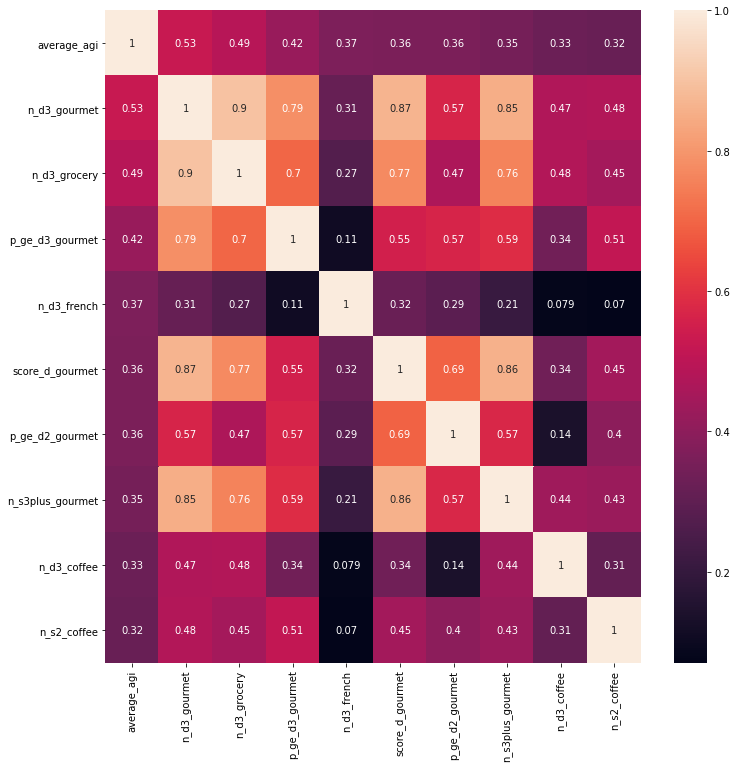

In [32]:
# Visualize correlations.

# Set plot size.
plt.figure(figsize=(12,12))

# Create heatmap.
sns.heatmap(zip_df[highest_corr_cols].corr(), 
            annot=True)

### Save data.

In [33]:
# Save output for modeling.  

# Locate the file.
zip_csv = './data/composite_zip_WI.csv'

zip_df.to_csv(zip_csv, encoding='utf-8', index=False)